<a href="https://colab.research.google.com/github/brianbaert/MscThesis/blob/main/MscThesis_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
!python --version
#!pip install avalanche_lib[all]
#!pip install gwpy
#!pip install nds2
#!pip show avalanche-lib
#!pip show gwpy

Python 3.10.14


In [2]:
#%cd /content/drive/MyDrive/MscThesis
%pwd

'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis'

In [3]:
import numpy as np
import os
import pandas as pd
import time

from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [5]:
# Setting the correct directories
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
train_dir_2 = 'C:\\Users\Brian.Baert\\TrainingSet_CL_2'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

# Read in inverse weights used to cope with the imbalanced dataset
#class_weights_file = open("class_weights.txt", "r")
#temp = class_weights_file.read()
#temp_split = temp.split(", ")
#class_weights =  [float(weight) for weight in temp_split]

In [ ]:
meta_train_v1 = pd.read_csv('C:\\Users\\Brian.Baert\\GravitySpy\\trainingset_v1d1_metadata.csv')
print(meta_train_v1[meta_train_v1['sample_type']=='train']['label'].value_counts())
classes = meta_train_v1['label'].unique()

# DL Baseline

In [ ]:
train_set = my_dataloaders.GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=my_transformations.transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=my_transformations.transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=number_of_workers)
test_set = my_dataloaders.GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=my_transformations.transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
train_set = my_dataloaders.GravitySpy_0_5_dataset(root=train_dir, cls=classes, transform=my_transformations.transformGray)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)
val_set = my_dataloaders.GravitySpy_0_5_dataset(root=val_dir, cls=classes, transform=my_transformations.transformGray)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)
test_set = my_dataloaders.GravitySpy_0_5_dataset(root=test_dir, cls=classes, transform=my_transformations.transformGray)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
print("The training loader contains {} instances, the val loader contains {} instances and the test loader contains {} instances".format(len(train_loader), len(val_loader), len(test_loader)))

In [ ]:
class_counts = train_set.count_class_instances()
class_weights = []
for class_name, count in class_counts.items():
  print(f"{class_name}: {count} instances")
  class_weights.append(1.0/(count/len(train_set)))

class_weights

with open("class_weights.txt", "w") as output:
    output.write(str(class_weights))

In [ ]:
# Create Neural Network architecture for finetuning
myNet = my_architectures.BaselineGrayscaleNet_resnet18()
myNet.to(device)
print(myNet)

In [ ]:
# Pytorch Training loop
epoch_test_loss = 0
epoch_test_acc = 0
epoch_test_correct = 0
epoch_test_total = 0
best_vloss = 1_000_000.
avg_loss = 0
last_loss = 0
timestamp = my_utils.get_timestamp()

# Define the loss function and optimizer
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)
optimizer = Adam(myNet.parameters(), lr=0.001, weight_decay=1e-3) #LR from the study of Tiago Fernandes

# Number of epochs to train for
num_epochs = 10
epoch_number = 0

start = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
  total_correct = 0
  total_samples = 0
  print('EPOCH {}: '.format(epoch_number + 1))
  train_loss = 0.0
  myNet.train(True)

  ## TRAINING ONE EPOCH
  for i, data in enumerate(train_loader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = myNet(inputs)
    # compute loss and gradient
    loss = criterion(outputs, labels)
    #add part of regularization
    l2_reg = torch.tensor(0.0)
    for param in myNet.parameters():
      if param.requires_grad: #exclude frozen layers
        l2_reg += torch.norm(param, p=2)
    loss += 1e-5 * l2_reg
    #end part of regularization
    loss.backward()
    # adjust learning weights
    optimizer.step()

    # print statistics
    _, predicted = torch.max(outputs, 1)
    train_loss += loss.item()
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    if i % 16 == 15:
      last_loss = train_loss / 16
      print('  batch {} loss: {}, acc: {}'.format(i+1, last_loss, 100*total_correct/total_samples))
      tb_x = epoch * len(train_loader) + i + 1
      train_loss=0.
    avg_loss = last_loss

  ## VALIDATION
  running_vloss = 0.0
  myNet.eval()

  # disable gradient computation for validation
  with torch.no_grad():
    for i, vdata in enumerate(val_loader):
      vinputs, vlabels = vdata
      vinputs, vlabels = vinputs.to(device), vlabels.to(device)
      voutputs = myNet(vinputs)
      vloss = criterion(voutputs, vlabels)
      running_vloss += vloss
  avg_vloss = running_vloss / (i+1)
  print('LOSS train {:.4f} valid {:.4f} after {} seconds'.format(avg_loss, avg_vloss, time.time()-start))

  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(myNet.state_dict(), model_path)

  #my_utils.checkpoint(myNet, f"epoch-{epoch}.pth")
  epoch_number += 1

end = time.time()
print('Training finished after ', end-start, ' seconds')

In [ ]:
#save model
#torch.save(myNet.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_0_5.pth')
torch.save(myNet.state_dict(), 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_0_5.pth')
print("Saved Pytorch Model state to thesis_baseline.pth")

In [ ]:
#myNet.load_state_dict(torch.load('/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_1_0.pth'))
myNet.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_baseline_finetune_1_0.pth'))

In [ ]:
my_utils.n_test_predictions(myNet, test_loader, classes, 20)

In [ ]:
y_pred_list, y_true_list = my_utils.get_predictions(myNet, test_loader)

In [ ]:
# Generate confusion matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('confusion_matrix_baseline_1_0.png')
plt.close()

In [ ]:
print(f"F1 Score for each class: {f1}")
print(f"The average F1 score is: {f1_score(y_true_list, y_pred_list, average='weighted')}")

In [ ]:
# Create a horizontal bar plot for F1 scores with different colors
plt.figure(figsize=(10,7))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.barh(np.arange(len(classes)), f1, color=colors, align='center', alpha=0.5)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('F1 Score')
plt.title('F1 Score for Each Class')
figTemp = plt.gcf()
plt.show()
plt.draw()
figTemp.savefig('f1_scores_baseline_1_0.png')
plt.close()

# CL Experiments

# 1) CLASS INCREMENTAL

## Model, dataloader, benchmark and eval plugin

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

# log to text file
text_logger = TextLogger(open("naive_log.txt", "a"))

# print to stdout
interactive_logger = InteractiveLogger()

csv_logger = CSVLogger()

classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [7]:
train_set = my_dataloaders.GravitySpy_2_0_dataset(root=train_dir, cls=classes, transform=my_transformations.transformAV_224_Crop)
val_set = my_dataloaders.GravitySpy_2_0_dataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_224)
test_set = my_dataloaders.GravitySpy_2_0_dataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_224)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = train_set.labels
test_set_av.targets = test_set.labels
val_set_av.targets = val_set.labels

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [8]:
# DEFINE THE BENCHMARK
# CL custom benchmark, here we opt for the generator New Classes (NC)
# Given a sequence of train and test datasets this creates the continual stream as a series of experiences.
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
    class_ids_from_zero_in_each_exp=False,
)

In [9]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation. It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [ ]:
my_utils.plot_first_image(train_loader_av)

In [ ]:
my_utils.plot_first_image(val_loader_av)

In [ ]:
my_utils.plot_first_image(test_loader_av)

## Naive strategy with cross entropy loss, adam and replay

In [ ]:
# OPTIMIZER and CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()
#criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [ ]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=20, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='train')]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_Naive_CL_2_0.pth')

In [ ]:
# SOME TEST PREDICTIONS
my_utils.n_test_predictions(model, test_loader_av, classes, 20)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_Naive_2_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_scores_Naive_2_0.png')

In [ ]:
results

## LwF strategy with cross entropy loss and adam optimizer
The experiments are done on a neural network starting with 2 output nodes and gradually adapting with each experience to 22, but also on a neural network with 22 output nodes and running over the experiences.

In [10]:
# SETTING UP DEVICE AND INSTANCE OF MODEL CLASS
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

# log to text file
text_logger = TextLogger(open("LwF_log.txt", "a"))

# print to stdout
interactive_logger = InteractiveLogger()

csv_logger = CSVLogger()

classes = my_utils.get_classes_from_dir(train_dir_2)
class_to_indx = my_utils.classes_to_indices(classes)

In [11]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

In [12]:
# OPTIMIZER and LOSS CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss()

In [13]:
# STRATEGY 
# ALPHA AND TEMPERATURE are taken from the paper by Oren & Wolf - "In defense of the Learning Without Forgetting for Task Incremental Learning"
cl_strategy = LwF(
    model=model, optimizer=optimizer, criterion=criterion, alpha=0.25, temperature=2.0, 
    train_mb_size=64, train_epochs=20, eval_mb_size=32, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set))] #Early stopping is not used here because LwF does not inherently support Early Stopping
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_LwF_CL_2_0.pth')

In [14]:
model.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_LwF_CL_2_0.pth'))

<All keys matched successfully>

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'Results/cm_LwF_2_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'Results/f1_scores_LwF_2_0.png')

According to Oren & Wolf ("In defense of the learning without forgetting for task incremental learning"), LwF mostly benefits from a Wide-ResNet netwrok rather than from deeper networks. 

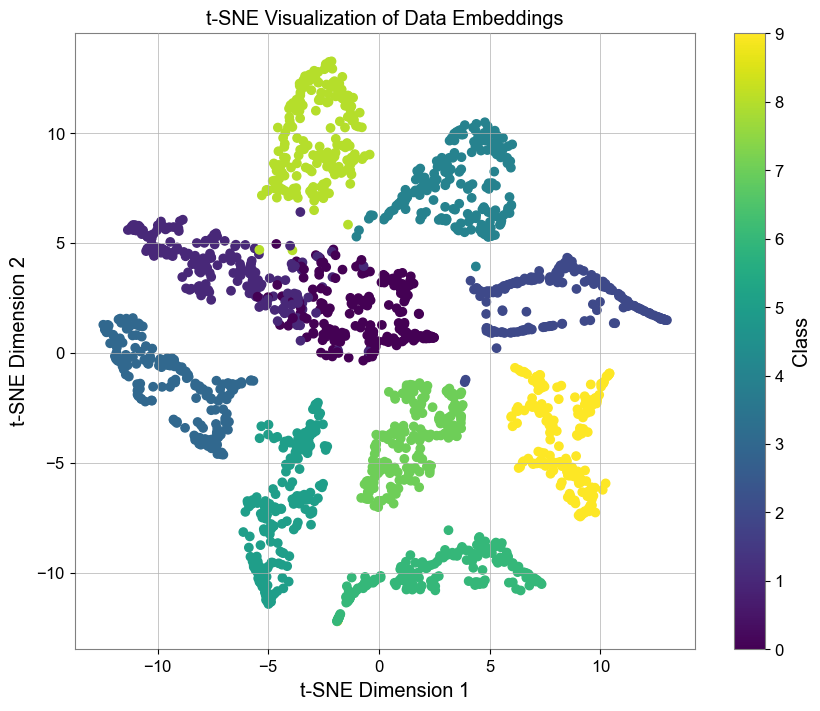

In [15]:
my_utils.plot_tSNE_data_embedding(model, train_loader_av, 'Results/tSNE_LwF_2_0.png')

## AGEM strategy with cross entropy loss and adam

In [ ]:
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

In [ ]:
# OPTIMIZER AND LOSS CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [ ]:
# STRATEGY
cl_strategy = AGEM(
    model=model, optimizer=optimizer, criterion=criterion, patterns_per_exp=11,
    train_mb_size=64, train_epochs=20, eval_mb_size=32, device=device, evaluator=eval_plugin,
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), AGEMPlugin(patterns_per_experience=11, sample_size=64)]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_AGEM_CL_1_0.pth')

In [ ]:
# CALCULATE PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_adaptive_AGEM_1_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_adaptive_AGEM_1_0.png')

In [ ]:
metric_dict = eval_plugin.get_all_metrics()
#for key in metric_dict.keys():
#    print(key)
metric_dict['Top1_Acc_Stream/eval_phase/train_stream/Task000']

In [ ]:
plt.clf()
plt.plot(metric_dict['Loss_Stream/eval_phase/train_stream/Task000'][1])
plt.title('Loss Stream')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['epoch'], loc='upper right')
plt.show()

## AR1 strategy with cross entropy loss and adam

In [ ]:
model = my_architectures.BaselineColorNet_resnet18()
model.to(device)

In [ ]:
# LOSS CRITERION
# AR1 uses SGD, there is no option to change the optimizer
criterion = CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)

In [ ]:
# AR1 STRATEGY
cl_strategy = AR1(criterion=CrossEntropyLoss(), lr=0.001, inc_lr=0.00005, init_update_rate = 0.01, train_epochs=20,
                  l2 = 0.0005, inc_update_rate = 0.00005, inc_step = 4.1e-05, rm_sz = 2*len(train_set), device=device)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers=4)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_AR1_CL_2_0.pth')

In [ ]:
# CALCULATE PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'cm_AR1_2_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'f1_AR1_2_0.png')

# TASK INCREMENTAL - Instance based

## Prerequisites

In [16]:
model = my_architectures.BaselineColorNet_resnet18(num_classes=10)
model.to(device)

BaselineColorNet_resnet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [17]:
train_set = my_dataloaders.GravitySpy_2_0_dataset(root=train_dir, cls=classes, transform=my_transformations.transformAV_224_Crop)
val_set = my_dataloaders.GravitySpy_2_0_dataset(root=val_dir, cls=classes, transform=my_transformations.transformAV_224)
test_set = my_dataloaders.GravitySpy_2_0_dataset(root=test_dir, cls=classes, transform=my_transformations.transformAV_224)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True, num_workers=number_of_workers)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

train_set_av.targets = train_set.labels
test_set_av.targets = test_set.labels
val_set_av.targets = val_set.labels

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [18]:
# DEFINE THE BENCHMARK
# CL custom benchmark, here we opt for the generator New Instances (NI)
# Given a sequence of train and test datasets this creates the continual stream as a series of experiences.
bm = ni_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=5,
    shuffle=True,
    seed=1234,
    task_labels=False,
)

In [19]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation. It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=False, stream=True),
    ram_usage_metrics(experience=True, stream=True, epoch=False),
    bwt_metrics(experience=True, stream=True),
    loggers=[interactive_logger, text_logger, csv_logger],
    strict_checks=False,
)

## Naive strategy with Adam and Cross Entropy Loss

In [ ]:
# OPTIMIZER and CRITERION
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = CrossEntropyLoss(label_smoothing=0.2)

In [ ]:
# NAIVE STRATEGY
cl_strategy = Naive(
    model=model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=20, 
    eval_mb_size=16, device=device, evaluator=eval_plugin, 
    plugins=[ReplayPlugin(mem_size=2*len(train_set)), EarlyStoppingPlugin(patience=2, val_stream_name='valid')]
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, model, optimizer, number_of_workers)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_TaskBased_Naive_CL_2_0.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Results\\cm_TaskBased_Naive_2_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Results\\f1_TaskBased_Naive_2_0.png')

## SCR (Supervised Contrastive Replay) 
Memory buffer: 1k, 2k
Model = ResNet18
Loss = SCR loss / Cross-entropy loss
Optimizer = SGD
Temperature = 0.1

In [36]:
from avalanche.training import SCR, SCRLoss
from avalanche.models import SCRModel
resnet18 = my_architectures.BaselineColorNet_resnet18(num_classes=10)
projection_network = nn.Linear(10, 512)  # Adjust the output size as needed
scr_model = SCRModel(feature_extractor=resnet18, projection=projection_network)
optimizer = SGD(model.parameters(), lr=0.001, weight_decay=1e-5) #although in the paper lr = 0.1 initially
criterion = CrossEntropyLoss(label_smoothing=0.2)
scr_model.to(device)

SCRModel(
  (ncm): NCMClassifier()
  (feature_extractor): BaselineColorNet_resnet18(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [37]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation. It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.
# Accuracy cannot be monitored during training of SCR. During training NCRLoss is monitored

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=False, experience=True, stream=True),
    #forgetting_metrics(experience=False, stream=True),
    #bwt_metrics(experience=True, stream=True),
    #forward_transfer_metrics(experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

In [39]:
# SCR STRATEGY
cl_strategy = SCR(
    model=scr_model, optimizer=optimizer, criterion=criterion, train_mb_size=32, train_epochs=2, 
    eval_mb_size=16, mem_size=1000, temperature=0.1, device=device, evaluator=eval_plugin
)

In [ ]:
# TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers)

Starting experiment with strategy: <avalanche.training.supervised.supervised_contrastive_replay.SCR object at 0x0000024740E0F9A0>
Start of experience:  0
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start of training phase << --
100%|██████████| 13/13 [01:30<00:00,  6.98s/it]
Epoch 0 ended.
100%|██████████| 13/13 [01:30<00:00,  6.97s/it]
Epoch 1 ended.
-- >> End of training phase << --
Training completed
Computing accuracy on the whole test set
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 72/72 [01:01<00:00,  1.18it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 2.1712
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.3747
-- >> End of eval phase << --
	Loss_Stream/eval_phase/test_stream/Task000 = 2.1712
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.3747
Start of experience:  1
Current Classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
-- >> Start 

In [ ]:
# SAVE MODEL
my_utils.checkpoint(scr_model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_TaskBased_Contrastive_CL_2_0.pth')

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(scr_model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Results\\cm_TaskBased_Contrastive_2_0.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Results\\f1_TaskBased_Contrastive_2_0.png')

In [ ]:
# load saved model
scr_model.load_state_dict(torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_TaskBased_Contrastive_CL_2_0.pth'))

In [ ]:
# load saved model to gpu
scr_model.to(device)

In [ ]:
my_utils.plot_tSNE_data_embedding(scr_model, train_loader_av, 'Results/tSNE_ScR_2_0.png')

In [ ]:
# second online TRAINING
results=[]
results = my_utils.cl_simple_train_loop(bm, cl_strategy, scr_model, optimizer, number_of_workers)

In [ ]:
# CALCULATE ALL PREDICTIONS
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = my_utils.get_predictions(scr_model, test_loader_av)

In [ ]:
# GENERATE CONFUSION MATRIX AND F1
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

In [ ]:
# SAVE MODEL
my_utils.checkpoint(scr_model, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_TaskBased_Contrastive_CL_2_0_SecondTraining.pth')

In [ ]:
# PLOT CM
my_utils.plot_confusion_matrix(cm, classes, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Results\\cm_TaskBased_Contrastive_2_0_SecondTraining.png')

In [ ]:
# PLOT F1
my_utils.plot_f1_scores(f1, classes, 'C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Results\\f1_TaskBased_Contrastive_2_0_SecondTraining.png')

In [ ]:
temp = torch.load('C:\\Users\\Brian.Baert\\Documents\\GitHub\\MscThesis\\Models\\thesis_TaskBased_Contrastive_CL_2_0_SecondTraining.pth')
scr_model.load_state_dict(temp)

In [ ]:
my_utils.plot_tSNE_data_embedding(temp, train_loader_av, 'Results/tSNE_ScR_2_0.png')